<center><b><font size=6>Unsupervised learning – clustering<b><center>

This notebook performs the following tasks for analyzing attack data.

0. **Install Dependencies**
1. **Determine the Number of Clusters**
2. **Tune Other Hyperparameters**
3. **Visualize the Clusters**
4. **Cluster Analysis**
5. **Assess Homogeneity and Intent Reflection**
6. **Associate Clusters with Specific Attack Categories**

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section3

Installing common packages: pandas, pyarrow
  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
Installing Section 3 packages: numpy, matplotlib, seaborn, scikit-learn, wordcloud
  Using cached wordcloud-1.9.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from collections import Counter 
import itertools
import math

# utils
import sys
sys.path.append("../")
from scripts.data_storage_utils import save_plot

In [3]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section3"

<center><b><font size=5>Determine the Number of Clusters<b><center>

Identify the optimal number of clusters using evaluation methods like the Elbow Method or Silhouette Analysis.

**Steps:**

- Evaluate Data for Clustering
- Apply Clustering Evaluation Techniques
- Decide and Document

### Evaluate Data for Clustering

- Preprocess the text sessions (e.g., tokenize and vectorize using TF-IDF or word embeddings).
- Ensure data is normalized and ready for clustering.

In [4]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
SSH_Attacks

session_id                                       full_session  \
0                0  [enable, system, shell, sh, cat, /proc/mounts,...   
1                1  [enable, system, shell, sh, cat, /proc/mounts,...   
2                2  [enable, system, shell, sh, cat, /proc/mounts,...   
3                3  [enable, system, shell, sh, cat, /proc/mounts,...   
4                4  [enable, system, shell, sh, cat, /proc/mounts,...   
...            ...                                                ...   
233030      233042  [cat, /proc/cpuinfo, grep, name, wc, -l, echo,...   
233031      233043  [cat, /proc/cpuinfo, grep, name, wc, -l, echo,...   
233032      233044  [cat, /proc/cpuinfo, grep, name, wc, -l, echo,...   
233033      233045  [cat, /proc/cpuinfo, grep, name, wc, -l, echo,...   
233034      233046  [cat, /proc/cpuinfo, grep, name, wc, -l, echo,...   

                        first_timestamp               Set_Fingerprint  
0      2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]  
1      2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]  
2      2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]  
3      2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]  
4      2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]  
...                                 ...                           ...  
233030 2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]  
233031 2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]  
233032 2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]  
233033 2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]  
233034 2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]  

[233035 rows x 4 columns]

In [5]:
df_features_tfidf_sampled = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")


X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
df_features_tfidf_sampled

Set_Fingerprint  0kx34uax1rv  15s  172  192  20m   3s  \
0       [Defense Evasion, Discovery]          0.0  0.0  0.0  0.0  0.0  0.0   
1       [Defense Evasion, Discovery]          0.0  0.0  0.0  0.0  0.0  0.0   
2       [Defense Evasion, Discovery]          0.0  0.0  0.0  0.0  0.0  0.0   
3       [Defense Evasion, Discovery]          0.0  0.0  0.0  0.0  0.0  0.0   
4       [Defense Evasion, Discovery]          0.0  0.0  0.0  0.0  0.0  0.0   
...                              ...          ...  ...  ...  ...  ...  ...   
233030      [Discovery, Persistence]          0.0  0.0  0.0  0.0  0.0  0.0   
233031      [Discovery, Persistence]          0.0  0.0  0.0  0.0  0.0  0.0   
233032      [Discovery, Persistence]          0.0  0.0  0.0  0.0  0.0  0.0   
233033      [Discovery, Persistence]          0.0  0.0  0.0  0.0  0.0  0.0   
233034      [Discovery, Persistence]          0.0  0.0  0.0  0.0  0.0  0.0   

        75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw  \
0                                                     0.0                                                                                                                                                                                                  
1                                                     0.0                                                                                                                                                                                                  
2                                                     0.0                                                                                                                                                                                                  
3                                                     0.0                                                                                                                                                                                                  
4                                                     0.0                                                                                                                                                                                                  
...                                                   ...                                                                                                                                                                                                  
233030                                                0.0                                                                                                                                                                                                  
233031                                                0.0                                                                                                                                                                                                  
233032                                                0.0                                                                                                                                                                                                  
233033                                                0.0                                                                                                                                                                                                  
233034                                                0.0                                                                                                                                                                                                  

         8m  9p7vd0epz3tz  ...        up       var        w

### Apply Clustering Evaluation Techniques

- Use the Elbow Method:
  - Calculate the sum of squared distances (inertia) for a range of cluster numbers.
  - Plot inertia vs. the number of clusters to identify the "elbow" point.
- Use Silhouette Analysis:
  - Compute the silhouette score for each potential cluster number.
  - Plot silhouette scores to find the number with the highest score.

### Decide and Document

- Select the optimal number of clusters based on the evaluation.
- Visualize and explain the reasoning with supporting metrics and charts.

In [ ]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
silhouette_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 17):
    kmeans_new = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cl_labels = kmeans_new.fit_predict(X)
        
    silhouette_value= silhouette_score(X, kmeans_new.labels_)
    silhouette_list.append(silhouette_value)

    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

In [ ]:
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set_theme(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "k-means_clustering_error", "png", global_overwrite)

# Show the plot
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "k-means_silohuette_score", "png", global_overwrite)

# Show the plot
plt.show()

(unique, counts) = np.unique(kmeans_new.labels_, return_counts=True)
print("Size of each cluster: ", counts)

In [ ]:
n_cluster_list=[]
silhouette_list_gmm= []
log_l_list=[]

for n_clusters in range(3, 17):
    gmm = GaussianMixture(n_components = n_clusters, random_state=42)
    gmm_label = gmm.fit_predict(X)
      
    silhouette_value = silhouette_score(X, gmm_label)
    silhouette_list_gmm.append(silhouette_value)
    
    log_l_list.append(gmm.score(X))
    n_cluster_list.append(n_clusters)

In [ ]:
# Set up Seaborn style
sns.set_theme(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "gmm_total_log-likelihood_score", "png", global_overwrite)

# Show the plot
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list_gmm, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "gmm_silohuette_score", "png", global_overwrite)

# Show the plot
plt.show()

# report effective size
print("Effetive size of each cluster: ", gmm.weights_)

<center><b><font size=5>Tune Other Hyperparameters<b><center>

## KMEANS

In [6]:
param_grid_kmeans = {
    'init': ['k-means++', 'random'],
    'n_init':  list(range(10, 21, 2)),
    'max_iter':  list(range(50, 200, 50)),
}

# Create KMeans object
kmeans = KMeans(n_clusters=10, random_state=42)

# Create RandomizedSearchCV object
grid_search_kmeans = GridSearchCV(kmeans, param_grid = param_grid_kmeans, cv=5)

# Fit the randomized search to your data
grid_search_kmeans.fit(X)  # X is your dataset

# Get the best parameters
best_params_kmenas = grid_search_kmeans.best_params_
print("Best parameters:", best_params_kmenas)

Best parameters: {'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [7]:
kmeans_tuned = KMeans(n_clusters=6, init=best_params_kmenas['init'], n_init=best_params_kmenas['n_init'], max_iter=best_params_kmenas['max_iter'], random_state=42)
cl_labels_tuned = kmeans_tuned.fit_predict(X)
    
silhouette_value= silhouette_score(X, kmeans_tuned.labels_)

inertia = (kmeans_tuned.inertia_)
print("Silhouette: ", silhouette_value)
print("Inertia: ", inertia)

Silhouette:  0.9538548083085323
Inertia:  2755.6217760542063


## GMM

In [8]:
def silhouette_scorer(gmm, X):
    labels = gmm.fit_predict(X)
    return silhouette_score(X, labels)

param_grid_gmm = {
    'init_params': ['kmeans'], 
    'covariance_type': ['full', 'spherical'], # 'tied', 'diag' have been deleted because never selected
    'tol': [1e-3, 1e-4, 1e-5], 
    'max_iter': list(range(50, 300, 50)),
}

# Create GaussianMixture object
gmm = GaussianMixture(n_components=10,random_state=42)

# Create GridSearchCV object
grid_search_gmm = GridSearchCV(gmm, param_grid_gmm, cv=5, scoring = silhouette_scorer)

# Fit the grid search to your data
grid_search_gmm.fit(X)  # X is your dataset

# Get the best parameters
best_params_gmm = grid_search_gmm.best_params_
print("Best parameters:", best_params_gmm)

Best parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50, 'tol': 0.001}


In [9]:
gmm_tuned = GaussianMixture(n_components = 6, random_state=42, init_params=best_params_gmm['init_params'], covariance_type=best_params_gmm['covariance_type'], max_iter=best_params_gmm['max_iter'], tol=best_params_gmm['tol'])
gmm_label_tuned = gmm_tuned.fit_predict(X)
    
silhouette_value = silhouette_score(X, gmm_label_tuned)

log_l_tuned = (gmm_tuned.score(X))

print("Silhouette: ", silhouette_value)
print("Log-l: ", log_l_tuned)

Silhouette:  0.9503352402278286
Log-l:  501.1820436749146


<center><b><font size=5>Visualize the Clusters: t-SNE<b><center>

Use t-SNE or UMAP to create clear visual representations of the clusters.

**Steps:**

- Reduce Dimensionality
- Create Visual Representations
- Analyze and Save

### Reduce Dimensionality

- Apply t-SNE or UMAP to reduce the data to two or three dimensions for visualization.
- Normalize or scale data if required by the algorithm.

In [10]:
# LET'S APPLY THE t-SNE TO THE DATASET, TO REDUCE THE NUMBER OF COMPONENTS

originalDF = pd.DataFrame(X)

tsne = TSNE(n_components=2, random_state=42).fit_transform(originalDF.values)

df_tsne = pd.DataFrame(tsne)
df_tsne

# NOW WE HAVE THE 2 COMPONENTS and WE CAN APPLY IT TO BOTH THE ALGORITHM

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0          1
0      -1.703786 -12.167911
1      -1.703786 -12.167911
2      -1.703786 -12.167911
3      -1.703786 -12.167911
4      -1.703786 -12.167911
...          ...        ...
233030  1.439273   0.183800
233031 -0.046411   0.818869
233032  0.142102  -0.408442
233033 -1.064434  -3.327869
233034 -0.375861   0.807303

[233035 rows x 2 columns]

### Create Visual Representations

- Plot the data points with cluster assignments using a scatter plot:
  - Assign distinct colors to each cluster.
  - Add legends and labels for clarity.

## KMEANS

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  del sys.path[0]


Overwriting file: '../results/figures/plots/section3/tsne_kmeans_clusters.png'
Plot saved successfully at: '../results/figures/plots/section3/tsne_kmeans_clusters.png'


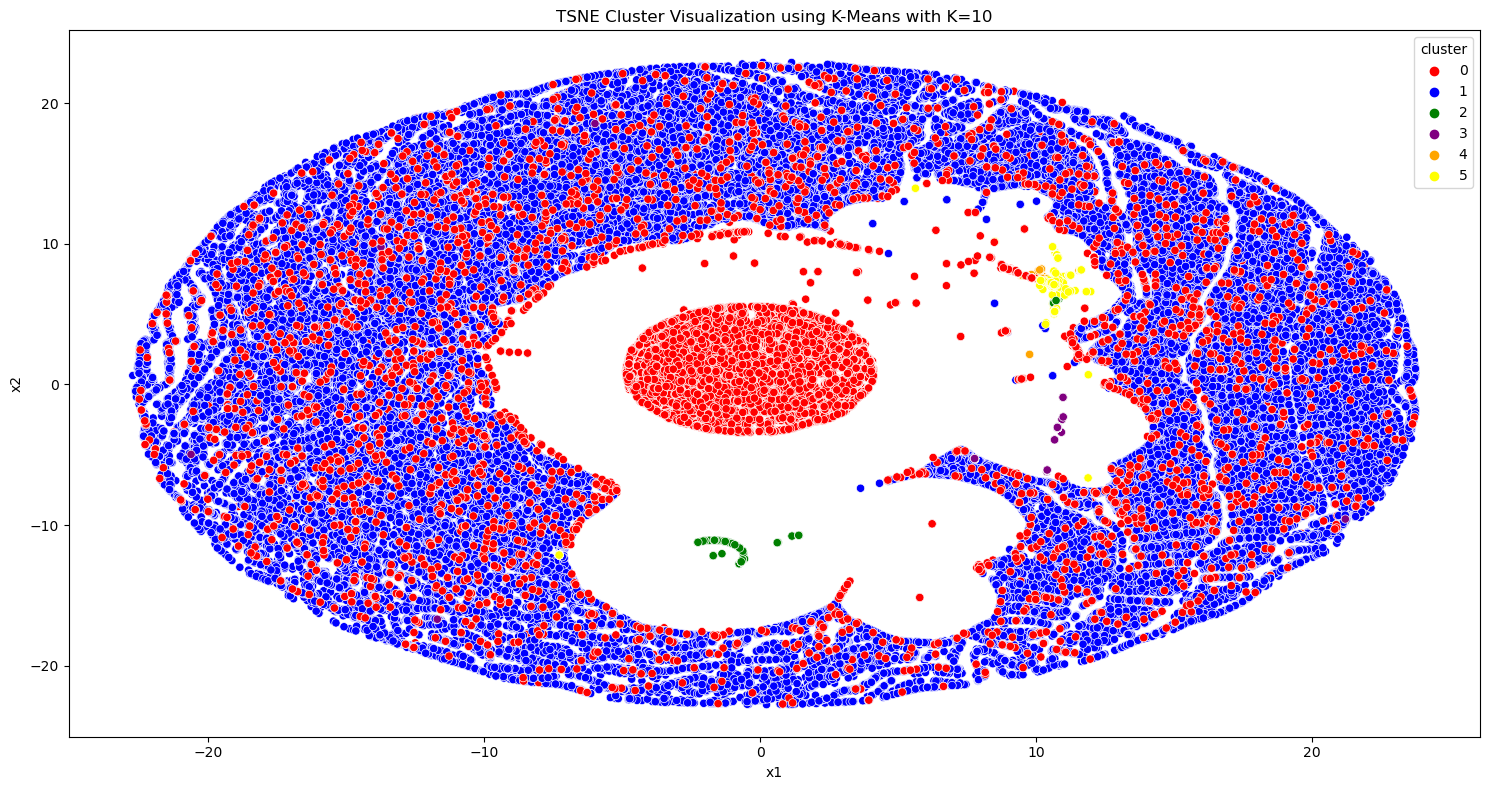

x1         x2  cluster
0      -1.703786 -12.167911        2
1      -1.703786 -12.167911        2
2      -1.703786 -12.167911        2
3      -1.703786 -12.167911        2
4      -1.703786 -12.167911        2
...          ...        ...      ...
233030  1.439273   0.183800        0
233031 -0.046411   0.818869        0
233032  0.142102  -0.408442        0
233033 -1.064434  -3.327869        0
233034 -0.375861   0.807303        0

[233035 rows x 3 columns]

In [11]:
labels_kmeans_tuned = kmeans_tuned.labels_

df_tsne_kmeans = pd.DataFrame(df_tsne)
df_tsne_kmeans["cluster"] = labels_kmeans_tuned
df_tsne_kmeans.columns = ["x1", "x2", "cluster"]

# Create the plot
fig, ax = plt.subplots(figsize=(15,8))

# Custom color palette to distinguish clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_kmeans, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")

ax.set_title('TSNE Cluster Visualization using K-Means with K=10')

# Save the plot
save_plot(fig, plot_directory, "tsne_kmeans_clusters", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

df_tsne_kmeans

## GMM

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  del sys.path[0]


Overwriting file: '../results/figures/plots/section3/tsne_gmm_clusters.png'
Plot saved successfully at: '../results/figures/plots/section3/tsne_gmm_clusters.png'


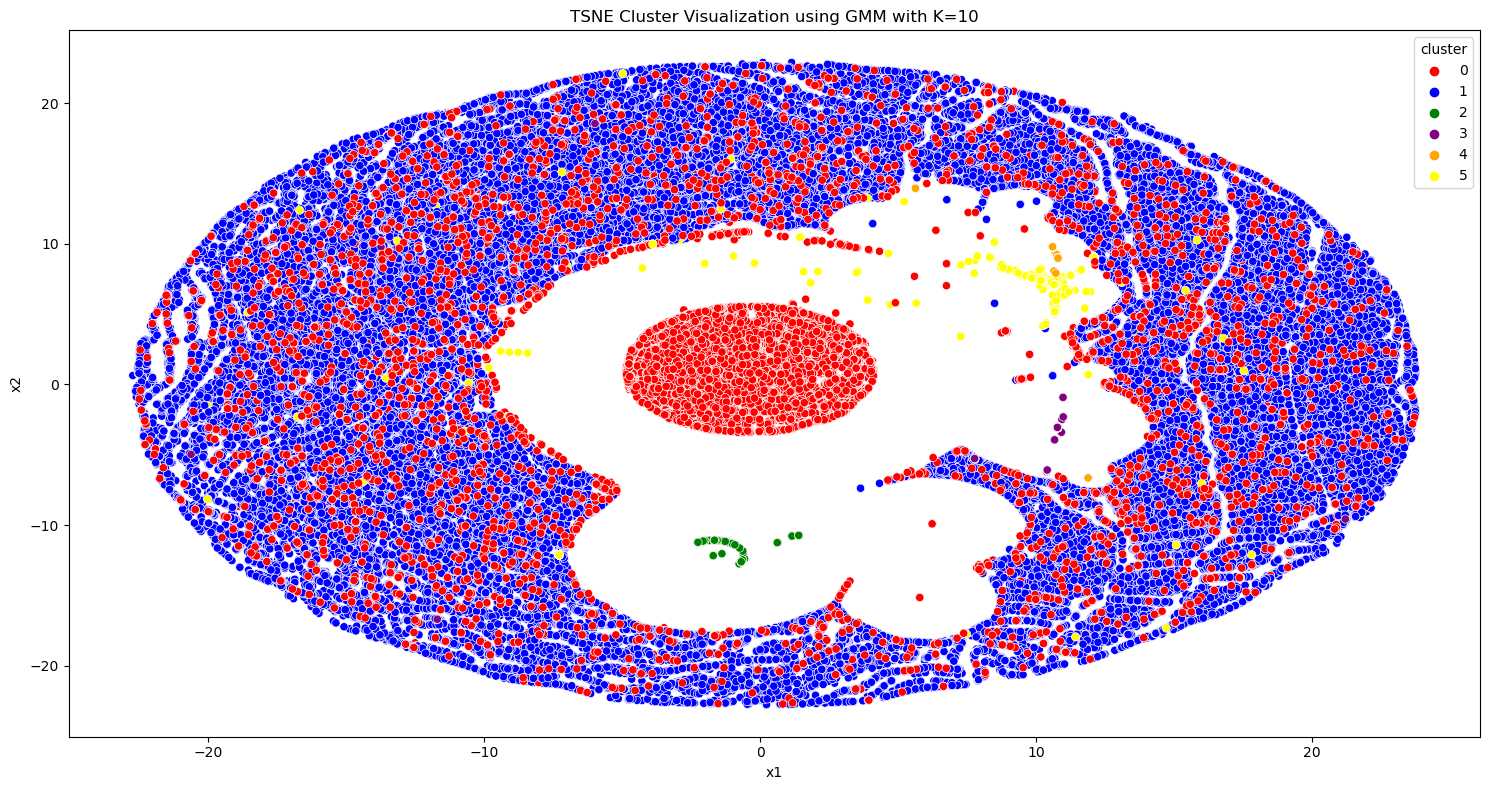

x1         x2  cluster
0      -1.703786 -12.167911        2
1      -1.703786 -12.167911        2
2      -1.703786 -12.167911        2
3      -1.703786 -12.167911        2
4      -1.703786 -12.167911        2
...          ...        ...      ...
233030  1.439273   0.183800        0
233031 -0.046411   0.818869        0
233032  0.142102  -0.408442        0
233033 -1.064434  -3.327869        0
233034 -0.375861   0.807303        0

[233035 rows x 3 columns]

In [12]:
labels_gmm_tuned = gmm_tuned.predict(X)

df_tsne_gmm = pd.DataFrame(df_tsne)
df_tsne_gmm["cluster"] = labels_gmm_tuned
df_tsne_gmm.columns = ["x1", "x2", "cluster"]

# Create the plot
fig, ax = plt.subplots(figsize=(15,8))

# Custom color palette to distinguish clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_gmm, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")

ax.set_title('TSNE Cluster Visualization using GMM with K=10')

# Save the plot
save_plot(fig, plot_directory, "tsne_gmm_clusters", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

df_tsne_gmm

### Analyze and Save

- Highlight overlaps or ambiguous clusters in the visualization.
- Save the plots and include them in your report for analysis.

Analyzing Cluster 2 - K-Means Community Detection
Plot saved successfully at: '../results/figures/plots/section3/k-means_graph_visualization_of_cluster_2_with_communities.png'


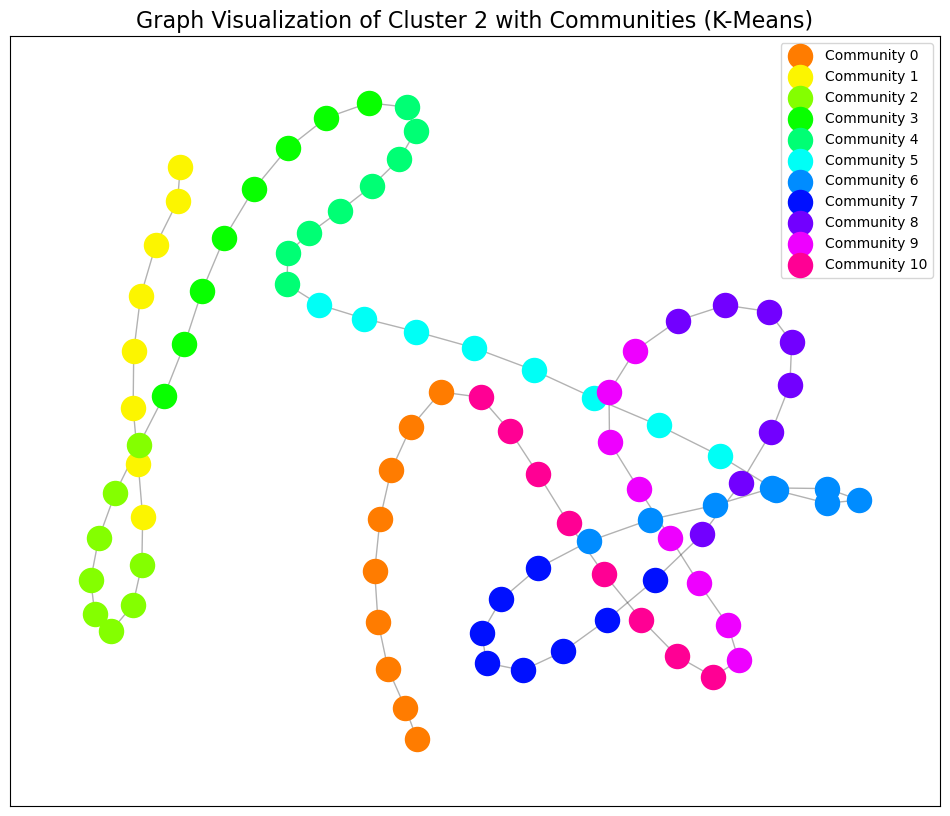

Cluster 2 - K-Means Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', '

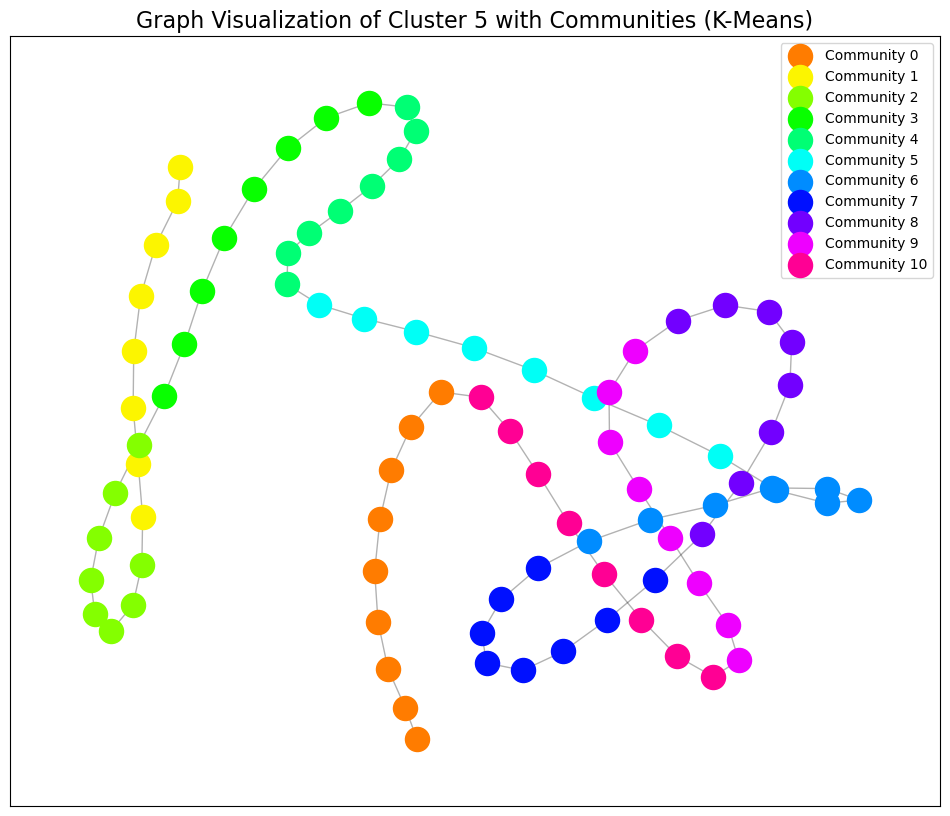

Cluster 5 - K-Means Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', '

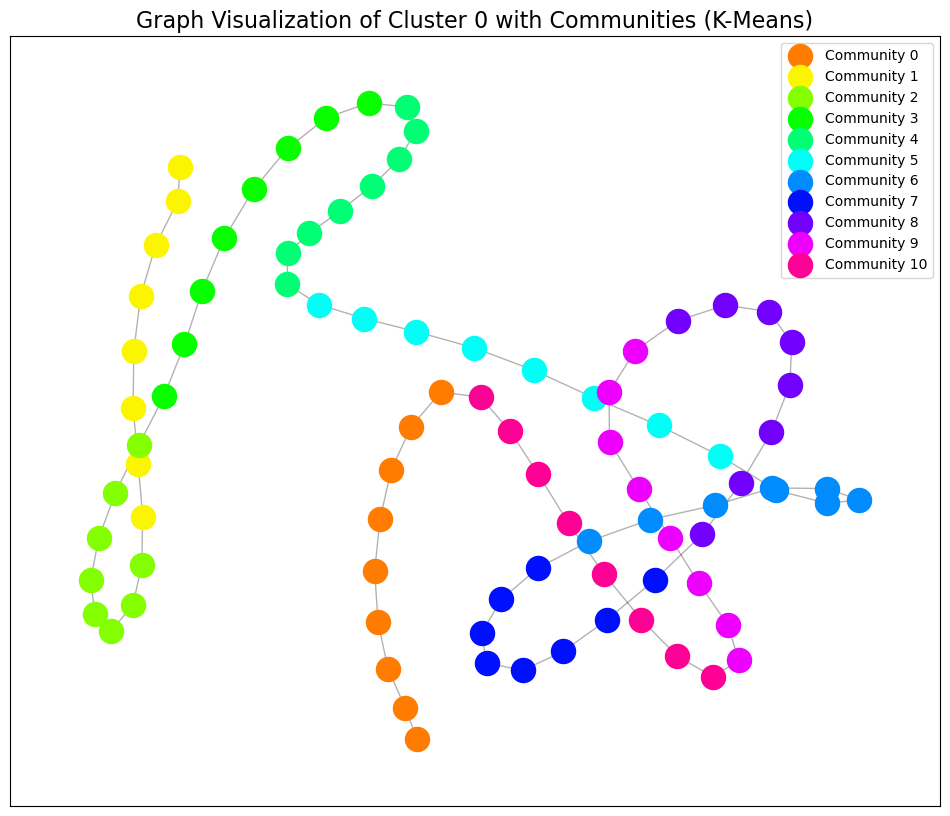

Cluster 0 - K-Means Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', '

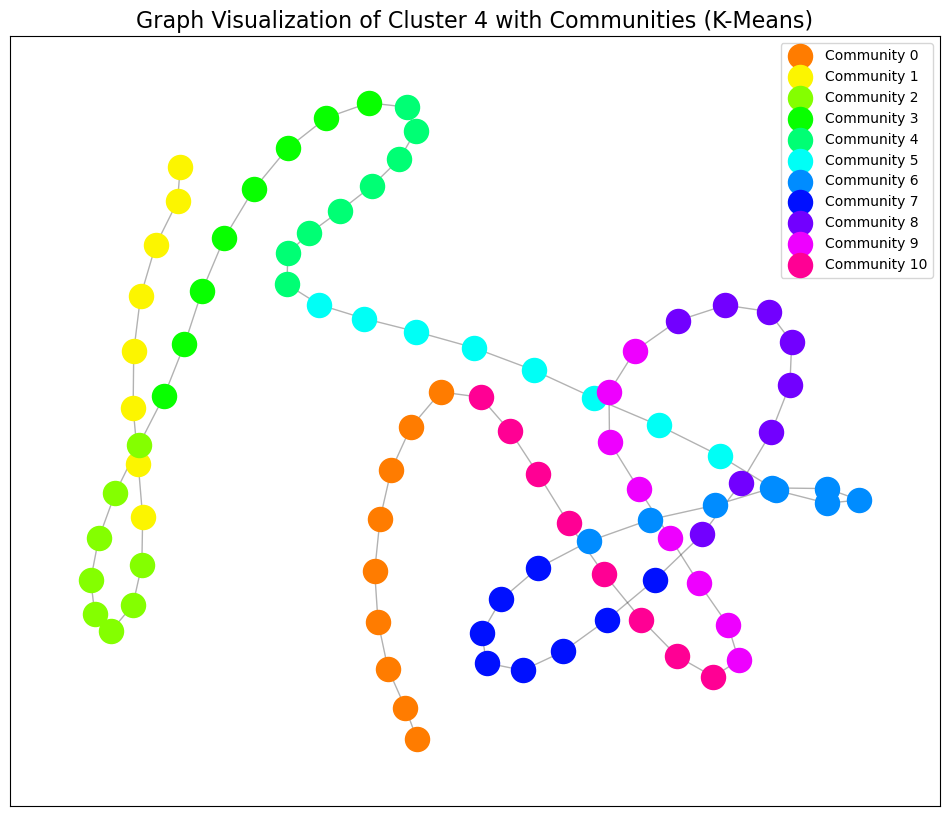

Cluster 4 - K-Means Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', '

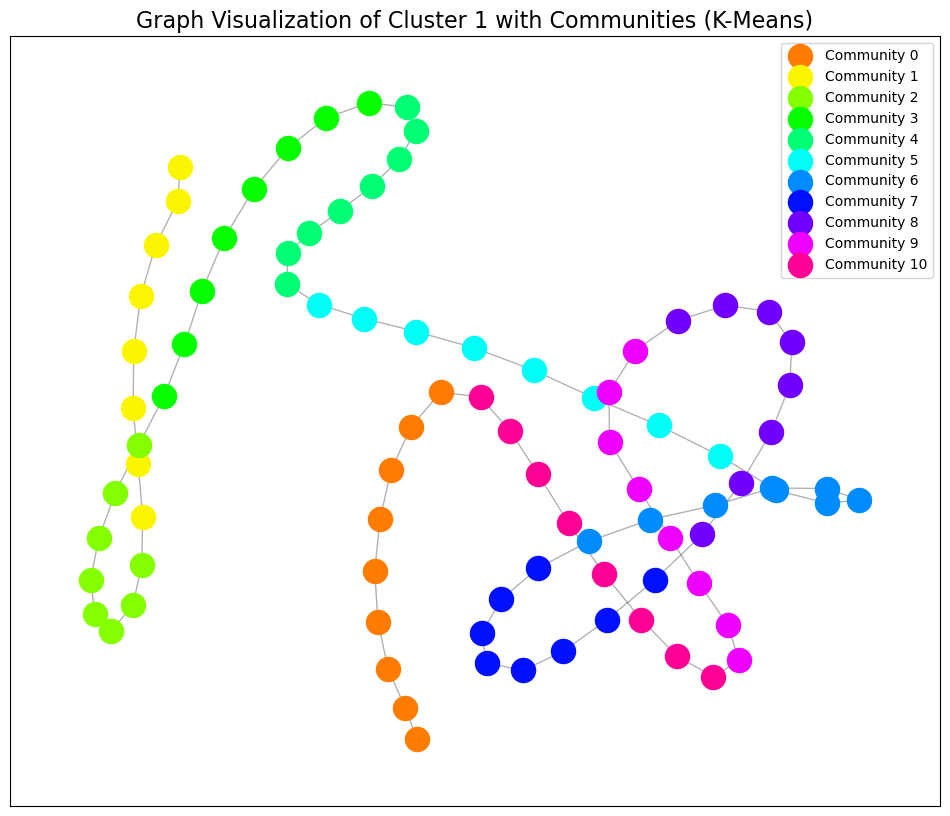

Cluster 1 - K-Means Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', '

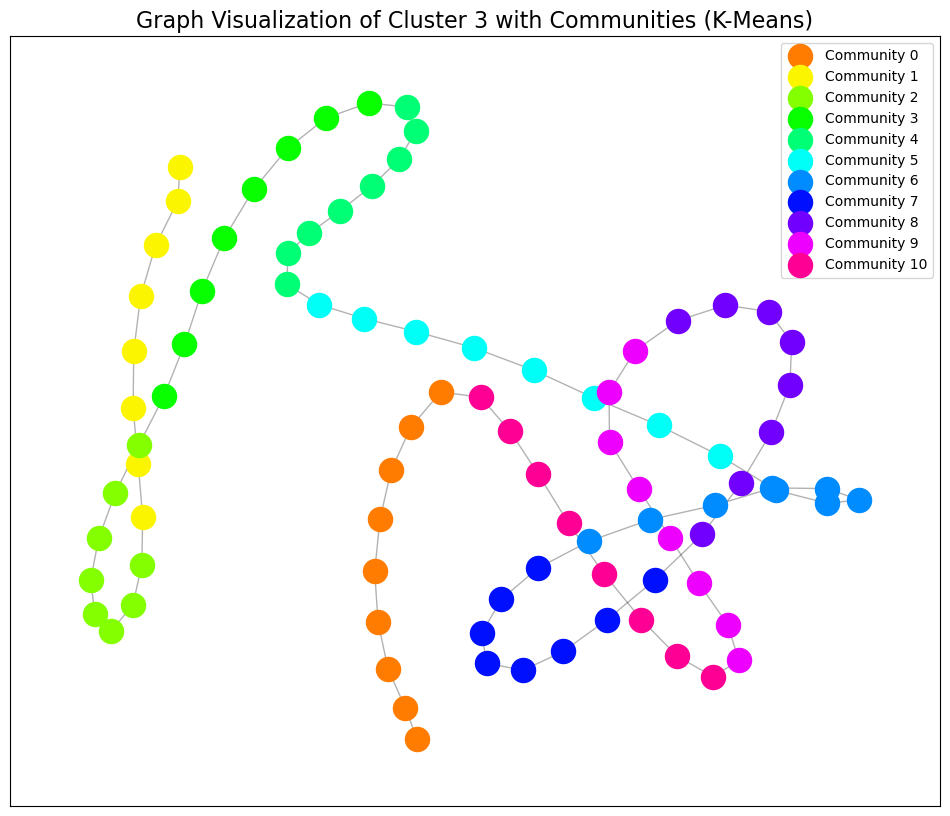

Cluster 3 - K-Means Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', '

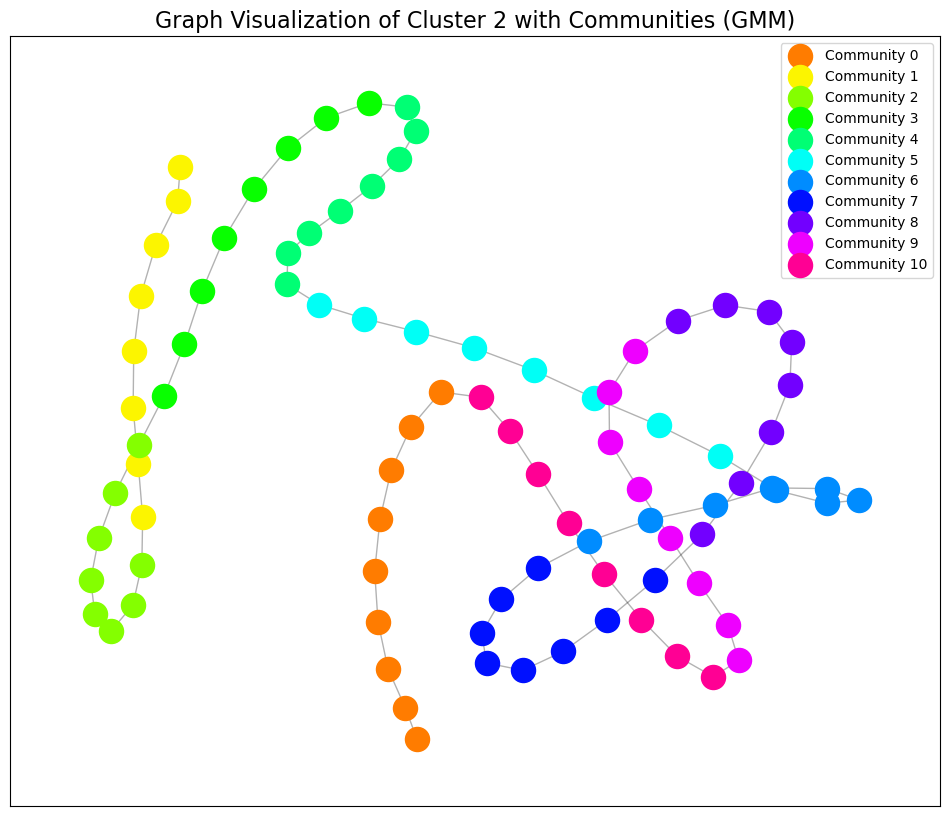

Cluster 2 - GMM Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', 'nohu

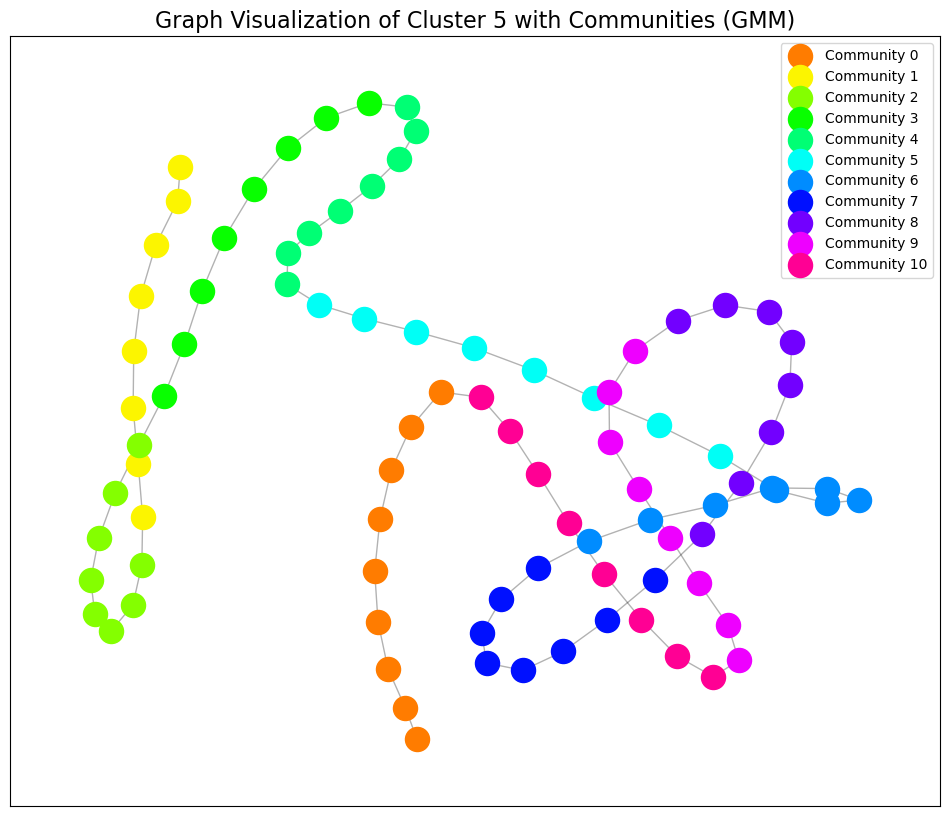

Cluster 5 - GMM Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', 'nohu

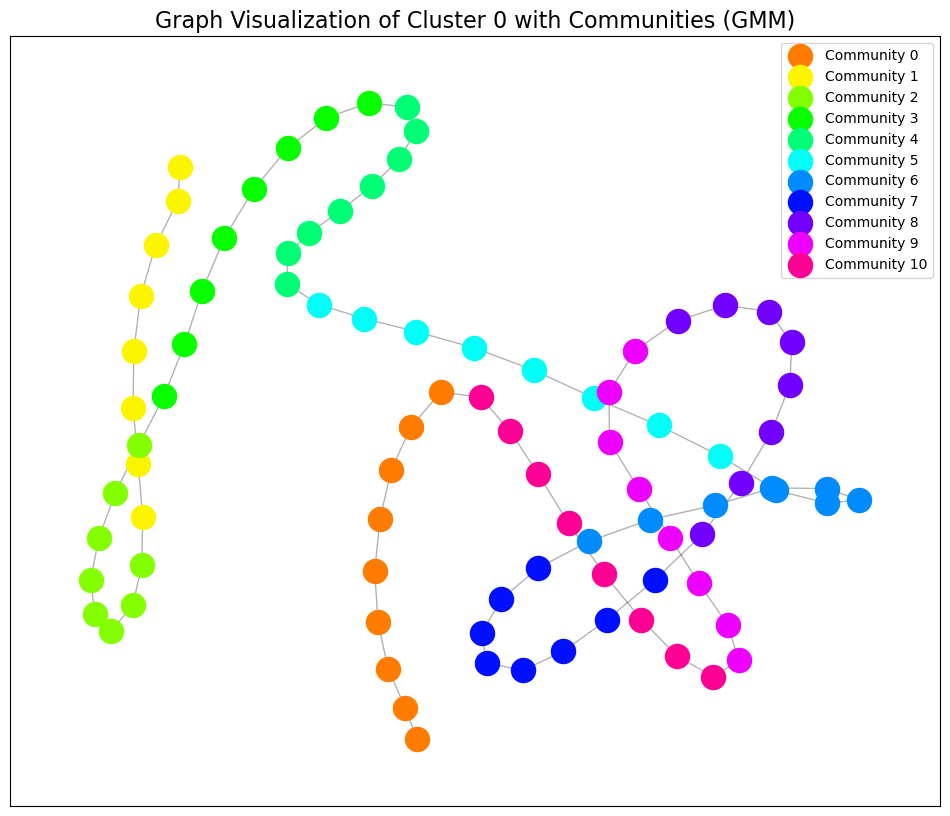

Cluster 0 - GMM Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', 'nohu

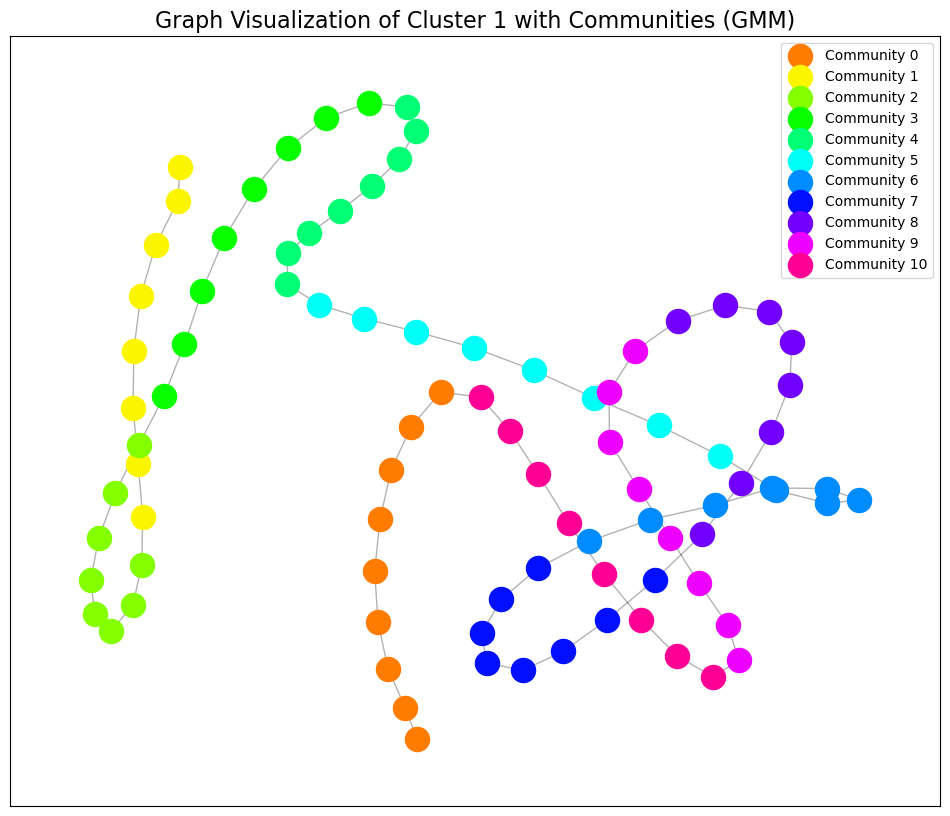

Cluster 1 - GMM Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', 'nohu

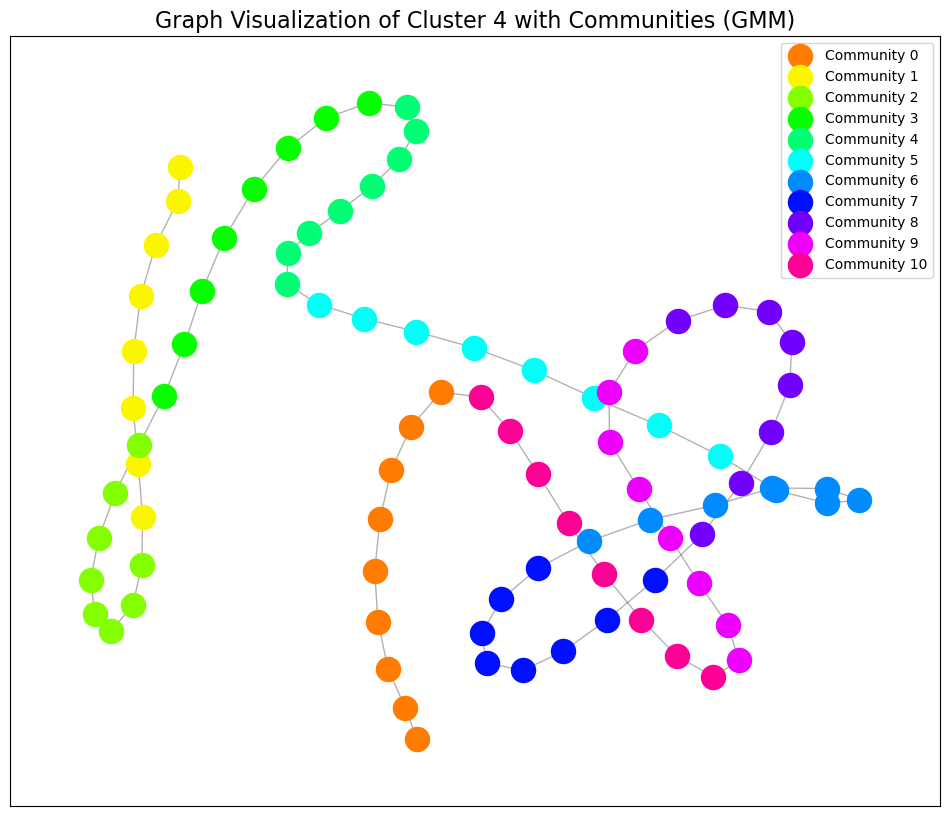

Cluster 4 - GMM Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', 'nohu

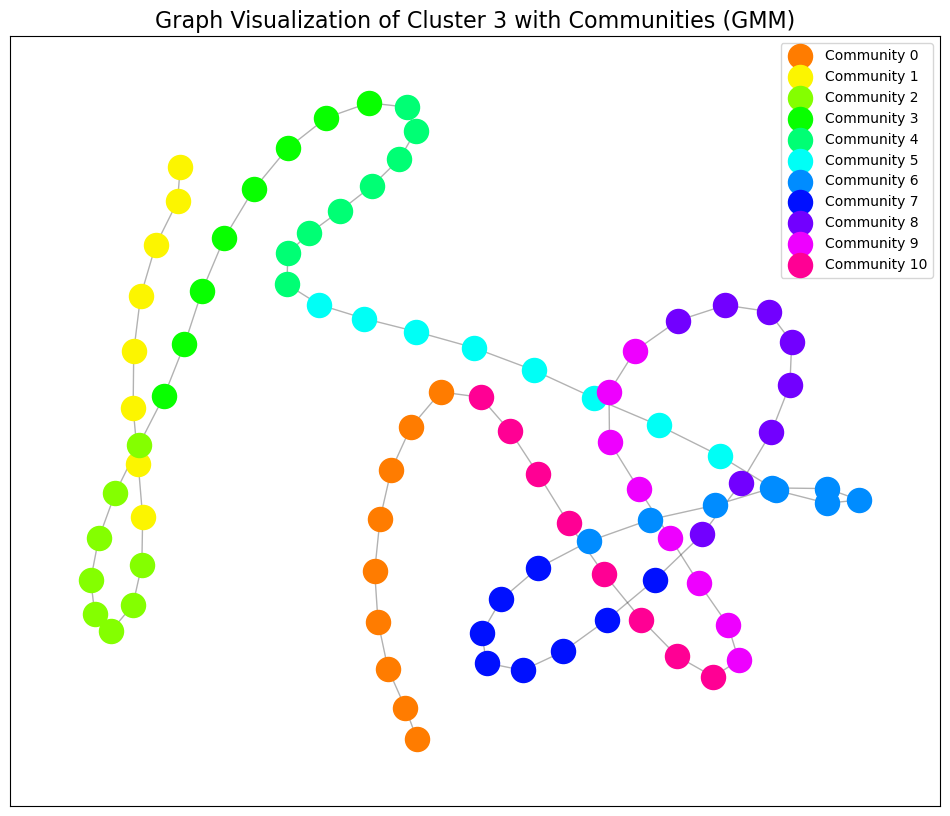

Cluster 3 - GMM Community Analysis:
Community 0:
['which', 'xf', 'wget', 'x17', 'while', 'x13', 'var', 'x19', 'wc']


Community 1:
['8m', '192', '3s', '0kx34uax1rv', '20m', '15s', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '172']


Community 2:
['bash', 'authorizedkeys', '9p7vd0epz3tz', 'awk', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'bin', 'bs', 'admin']


Community 3:
['busybox', 'count', 'chmod', 'cat', 'cp', 'cpuinfo', 'cd', 'chpasswd']


Community 4:
['do', 'dd', 'dota', 'echo', 'crontab', 'dota3', 'dev', 'done']


Community 5:
['exit', 'if', 'enable', 'gz', 'grep', 'head', 'free', 'go']


Community 6:
['lh', 'mkdir', 'mem', 'lscpu', 'model', 'ls', 'mdrfckr', 'initall']


Community 7:
['mounts', 'mv', 'null', 'password', 'nohu

In [13]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_and_visualize_clusters(df_tsne, df_features_tfidf_sampled, method, plot_directory, global_overwrite):
    unique_clusters = df_tsne["cluster"].unique()
    
    for cluster in unique_clusters:
        print(f"Analyzing Cluster {cluster} - {method} Community Detection")
        
        cluster_indices = df_tsne[df_tsne["cluster"] == cluster].index
        cluster_sessions = df_features_tfidf_sampled.iloc[cluster_indices]
        
        # Create a graph for session relationships
        G = nx.Graph()
        for idx, row in cluster_sessions.iterrows():
            session_words = row.drop("Set_Fingerprint").index  # Example, replace with meaningful data
            for i in range(len(session_words) - 1):
                G.add_edge(session_words[i], session_words[i + 1])
        
        # Use a community detection algorithm
        communities = list(greedy_modularity_communities(G))
        
        # Visualize the graph with communities
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(12, 10))
        colors = sns.color_palette('hsv', len(communities)).as_hex()
        
        for idx, community in enumerate(communities):
            nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=colors[idx], label=f'Community {idx}')
        nx.draw_networkx_edges(G, pos, alpha=0.3)
        
        plt.title(f'Graph Visualization of Cluster {cluster} with Communities ({method})', fontsize=16)
        plt.legend()
        
        # Save the plot
        current_fig = plt.gcf()
        save_plot(current_fig, plot_directory, f"{method.lower()}_graph_visualization_of_cluster_{cluster}_with_communities", "png", global_overwrite)
        
        # Show the plot
        plt.show()
        
        # Print community content
        print(f"Cluster {cluster} - {method} Community Analysis:")
        for idx, community in enumerate(communities):
            print(f"Community {idx}:")
            print(list(community)[:10])  # Show first 10 nodes as example
            print("\n")

# Run analysis for both K-Means and GMM
analyze_and_visualize_clusters(df_tsne_kmeans, df_features_tfidf_sampled, "K-Means", plot_directory, global_overwrite)
analyze_and_visualize_clusters(df_tsne_gmm, df_features_tfidf_sampled, "GMM", plot_directory, global_overwrite)

<center><b><font size=5>Cluster Analysis<b><center>

Examine and interpret each cluster’s defining characteristics using word clouds and frequent terms.

**Steps:**

- Identify Key Characteristics
- Describe Cluster Patterns
- Document Insights

### Identify Key Characteristics

- Extract the most frequent words or phrases in each cluster.
- Generate word clouds to visually represent the distinctive terms for each cluster.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


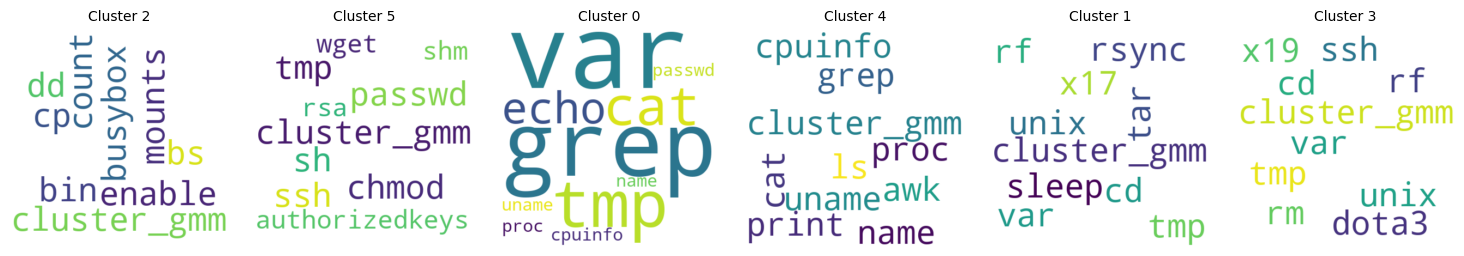

In [21]:

# Creazione del DataFrame da features e labels
df_cluster = pd.DataFrame(X)
df_cluster["cluster_kmeans"] = labels_kmeans_tuned

# Funzione per ottenere le parole più importanti per ciascun cluster
def get_top_words(df, n=10):
    top_words_per_cluster = {}
    for cluster in df["cluster_kmeans"].unique():
        subset = df[df["cluster_kmeans"] == cluster].drop(columns=["cluster_kmeans"])
        word_frequencies = subset.sum(axis=0)
        most_common_words = word_frequencies[word_frequencies > 0].sort_values(ascending=False).head(n).index.tolist()
        if most_common_words:
            top_words_per_cluster[cluster] = most_common_words
    return top_words_per_cluster

# Ottenere le parole chiave per ciascun cluster
top_words_per_cluster = get_top_words(df_cluster, n=10)

# Determinare il numero di cluster validi
num_clusters = len(top_words_per_cluster)

# Definiamo i parametri per la disposizione della griglia di subplot
columns = min(6, num_clusters)
rows = -(-num_clusters // columns)  # Ceiling division

# Creazione della figura con subplots
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, rows * 3))
axes = axes.flatten()

# Generazione delle word cloud per ciascun cluster
for idx, (cluster, words) in enumerate(top_words_per_cluster.items()):
    cluster_text = ' '.join(words)
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap="viridis").generate(cluster_text)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=10)
    axes[idx].axis('off')

# Rimuovere subplot vuoti
for j in range(num_clusters, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2)  # Più spazio tra i grafici
plt.show()


<center><b><font size=5>Assess Homogeneity and Intent Reflection<b><center>

Evaluate how well clusters align with intents and assess their homogeneity.

**Steps:**

- Match Clusters to Intents
- Analyze Homogeneity
- Draw Conclusions

### Match Clusters to Intents

- Compare each cluster to the dataset’s labeled intents (e.g., Persistence, Discovery, etc.).
- Use metrics like the homogeneity score or manual inspection to evaluate alignment.

Homogeneity Score: 0.8358

Intent Distribution Per Cluster:

Cluster 0:
Discovery          122825
Persistence        120391
Harmless             1788
Execution            1623
Defense Evasion       542
dtype: int64

Cluster 1:
Execution          84054
Discovery          84052
Persistence        84049
Other                310
Harmless             153
Defense Evasion       23
dtype: int64

Cluster 2:
Discovery          17613
Defense Evasion    17460
Execution             61
Harmless               2
dtype: int64

Cluster 3:
Discovery      5458
Execution      5458
Persistence    5458
Harmless          1
dtype: int64

Cluster 4:
Discovery          869
Persistence        853
Defense Evasion      1
Execution            1
dtype: int64

Cluster 5:
Execution          1730
Discovery          1328
Defense Evasion     973
Persistence         544
Harmless            262
Impact               27
Other                17
dtype: int64
Overwriting file: '../results/figures/plots/section3/intent_distributi

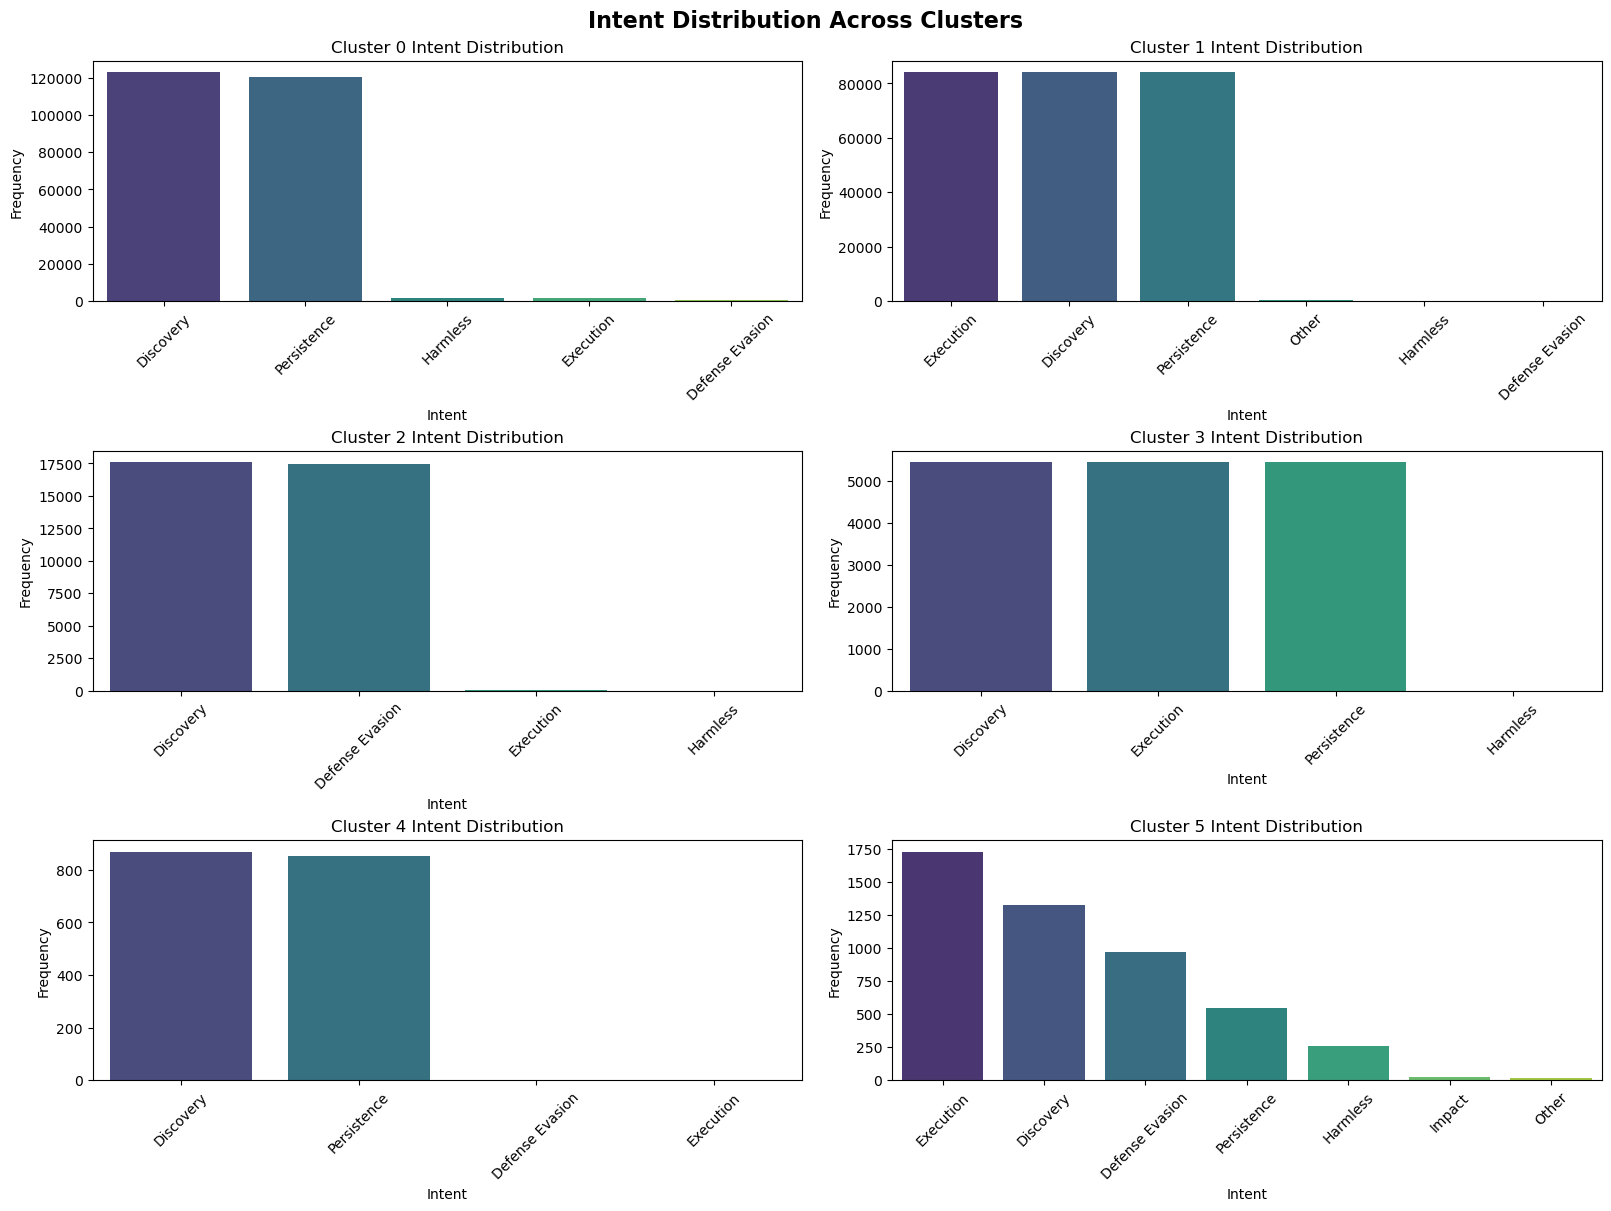

In [15]:
from sklearn.metrics import homogeneity_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math

def evaluate_cluster_homogeneity(df, labels, intent_col="Set_Fingerprint"):
    """
    Evaluate cluster homogeneity by comparing clusters to labeled intents.

    Args:
        df (pd.DataFrame): The dataset containing the intents.
        labels (list or array): Cluster labels assigned to each session.
        intent_col (str): Column name containing the intents.

    Returns:
        None: Displays metrics and visualizations.
    """
    # Convert intents to strings for homogeneity score calculation
    intents_as_strings = df[intent_col].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    
    # Calculate homogeneity score
    homogeneity = homogeneity_score(intents_as_strings, labels)
    print(f"Homogeneity Score: {homogeneity:.4f}")

    # Map clusters to intents
    df['cluster'] = labels
    cluster_intent_mapping = df.groupby('cluster')[intent_col].apply(lambda x: list(itertools.chain(*x)))

    # Visualize intent distribution per cluster
    print("\nIntent Distribution Per Cluster:")
    num_clusters = len(cluster_intent_mapping)
    num_columns = 2
    num_rows = math.ceil(num_clusters / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows), constrained_layout=True)

    for i, (cluster_label, intents) in enumerate(cluster_intent_mapping.items()):
        intent_counts = pd.Series(intents).value_counts()
        print(f"\nCluster {cluster_label}:")
        print(intent_counts)

        row_index = i // num_columns
        col_index = i % num_columns

        sns.barplot(ax=axes[row_index, col_index], x=intent_counts.index, y=intent_counts.values, palette='viridis')
        axes[row_index, col_index].set_title(f'Cluster {cluster_label} Intent Distribution', fontsize=12)
        axes[row_index, col_index].set_xlabel('Intent', fontsize=10)
        axes[row_index, col_index].set_ylabel('Frequency', fontsize=10)
        axes[row_index, col_index].tick_params(axis='x', rotation=45)

    # Hide empty subplots if the total number of clusters is not a multiple of num_columns
    for i in range(len(cluster_intent_mapping), num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle('Intent Distribution Across Clusters', fontsize=16, fontweight='bold')
    
    # Save the plot
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, "intent_distribution_across_clusters", "png", global_overwrite)

    # Show the plot
    plt.show()

# Match clusters to intents and evaluate homogeneity
evaluate_cluster_homogeneity(df_features_tfidf_sampled, labels_kmeans_tuned, intent_col="Set_Fingerprint")

### Analyze Homogeneity

- Check if clusters are homogeneous (single intent) or mixed (multiple intents).
- Record insights into intent distribution within clusters.

In [17]:
# Adding the Fingerprint column to df_cluster 
df_cluster = pd.DataFrame(X)
df_cluster["cluster_kmeans"] = labels_kmeans_tuned
df_cluster["cluster_gmm"] = labels_gmm_tuned
df_cluster['Set_Fingerprint'] = df_features_tfidf_sampled['Set_Fingerprint']
df_cluster

0kx34uax1rv  15s  172  192  20m   3s  \
0               0.0  0.0  0.0  0.0  0.0  0.0   
1               0.0  0.0  0.0  0.0  0.0  0.0   
2               0.0  0.0  0.0  0.0  0.0  0.0   
3               0.0  0.0  0.0  0.0  0.0  0.0   
4               0.0  0.0  0.0  0.0  0.0  0.0   
...             ...  ...  ...  ...  ...  ...   
233030          0.0  0.0  0.0  0.0  0.0  0.0   
233031          0.0  0.0  0.0  0.0  0.0  0.0   
233032          0.0  0.0  0.0  0.0  0.0  0.0   
233033          0.0  0.0  0.0  0.0  0.0  0.0   
233034          0.0  0.0  0.0  0.0  0.0  0.0   

        75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw  \
0                                                     0.0                                                                                                                                                                                                  
1                                                     0.0                                                                                                                                                                                                  
2                                                     0.0                                                                                                                                                                                                  
3                                                     0.0                                                                                                                                                                                                  
4                                                     0.0                                                                                                                                                                                                  
...                                                   ...                                                                                                                                                                                                  
233030                                                0.0                                                                                                                                                                                                  
233031                                                0.0                                                                                                                                                                                                  
233032                                                0.0                                                                                                                                                                                                  
233033                                                0.0                                                                                                                                                                                                  
233034                                                0.0                                                                                                                                                                                                  

         8m  9p7vd0epz3tz  \
0       0.0           0.0   
1       0.0           0.0   
2       0.0           0.0   
3       0.0           0.0   
4       0.0           0.0   
...     ...           ...   
233030  0.0           0.0   
233031  0.0           0.0   
233032  0.0           0.0   
233033  0.0           0.0   
233034  0.0           0.0   

        aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vv

In [18]:
df_cluster_exploded = df_cluster.explode("Set_Fingerprint").reset_index()

labels_intents = df_cluster_exploded["Set_Fingerprint"]
cluster_labels_kmeans = df_cluster_exploded["cluster_kmeans"]
cluster_labels_gmm = df_cluster_exploded["cluster_gmm"]

df_cluster_exploded

index  0kx34uax1rv  15s  172  192  20m   3s  \
0            0          0.0  0.0  0.0  0.0  0.0  0.0   
1            0          0.0  0.0  0.0  0.0  0.0  0.0   
2            1          0.0  0.0  0.0  0.0  0.0  0.0   
3            1          0.0  0.0  0.0  0.0  0.0  0.0   
4            2          0.0  0.0  0.0  0.0  0.0  0.0   
...        ...          ...  ...  ...  ...  ...  ...   
557921  233032          0.0  0.0  0.0  0.0  0.0  0.0   
557922  233033          0.0  0.0  0.0  0.0  0.0  0.0   
557923  233033          0.0  0.0  0.0  0.0  0.0  0.0   
557924  233034          0.0  0.0  0.0  0.0  0.0  0.0   
557925  233034          0.0  0.0  0.0  0.0  0.0  0.0   

        75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw  \
0                                                     0.0                                                                                                                                                                                                  
1                                                     0.0                                                                                                                                                                                                  
2                                                     0.0                                                                                                                                                                                                  
3                                                     0.0                                                                                                                                                                                                  
4                                                     0.0                                                                                                                                                                                                  
...                                                   ...                                                                                                                                                                                                  
557921                                                0.0                                                                                                                                                                                                  
557922                                                0.0                                                                                                                                                                                                  
557923                                                0.0                                                                                                                                                                                                  
557924                                                0.0                                                                                                                                                                                                  
557925                                                0.0                                                                                                                                                                                                  

         8m  9p7vd0epz3tz  ...      wget     which     while  x13  x17  x19  \
0       0.0           0.0  ...  0.154131  0.000000  0.156517  0.0  0.0  0.0   
1       0.0           0.0  ...  0.154131  0.000000  0.156517  0.0  0.0  0.0   
2       0.0           0.0  ...  0.154131  0.000000  0.156517  0.0  0.0  0.

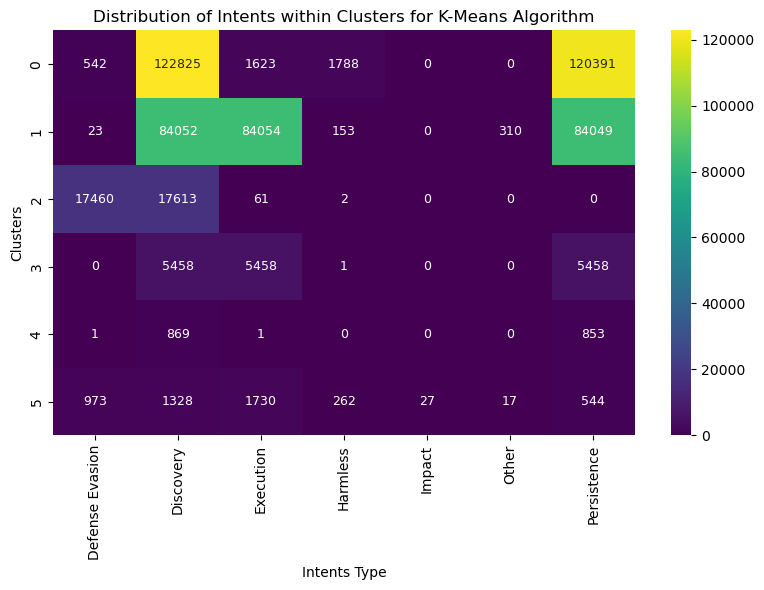

In [19]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_df = pd.DataFrame({'Set_Fingerprint': labels_intents, 'Cluster': cluster_labels_kmeans})
cluster_counts = cluster_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for K-Means Algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

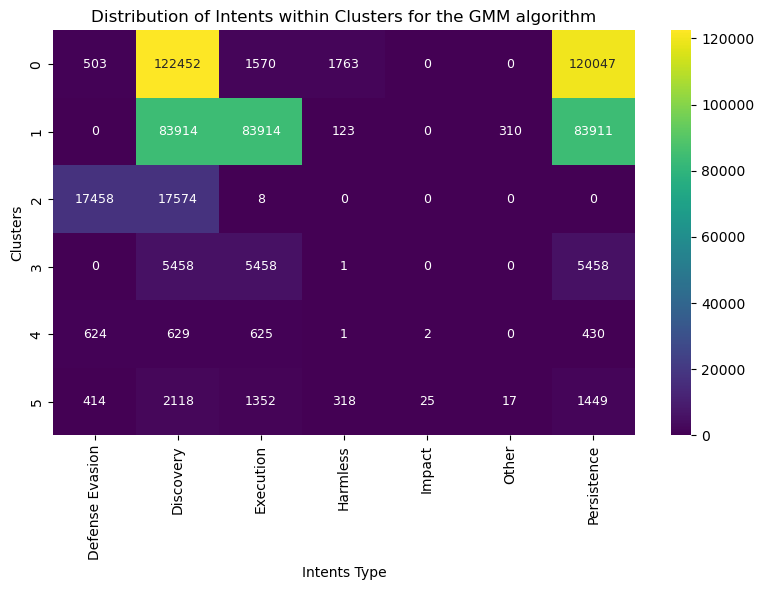

In [20]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_gmm_df = pd.DataFrame({'Set_Fingerprint': labels_intents, 'Cluster': cluster_labels_gmm})
cluster_counts_gmm = cluster_gmm_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts_gmm

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts_gmm, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for the GMM algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()